In [69]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
#from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 15})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [7, 5]
#from IPython.display import Audio, display
#def allDone():
#    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
#import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
#import emcee
import corner
#import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
#from multiprocessing import Pool
#import pickle
#import h5py
#import multiprocessing
#import itertools
#from multiproessing import sharedctypes
print('imported')
import scipy

imported


In [71]:
wdtable = Table.read('wdtable.fits')

In [73]:
wdtable

specnames,sigma_a,h3_a,h4_a,ghscale_a,ghcentre_a,sigma_b,h3_b,h4_b,ghscale_b,ghcentre_b,new_bbteff,source_id,bbteff,class [1],subclass [1],goodness [1],lgamma_alpha,ggamma_alpha,centre_alpha,scale_alpha,lgamma_beta,ggamma_beta,centre_beta,scale_beta,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,u_mag,g_mag,r_mag,i_mag,z_mag,w1mpro,w2mpro,cc_flags,var_flag,j_m,h_m,ks_m,g,abs_g,unit_error,Amp,var_metric_v0,var_metric_v1,abs_sdss_u,abs_sdss_g,abs_sdss_r,abs_sdss_i,abs_sdss_z,abs_w1,abs_w2,abs_j,abs_h,abs_ks,dg,N_spectra,Ha_L_gamma,Ha_L_line_wl,Ha_L_scale,Ha_L_asymmetry_500,Ha_L_asymmetry_1000,Ha_L_asymmetry_2000,Hb_L_gamma,Hb_L_line_wl,Hb_L_scale,Hb_L_asymmetry_500,Hb_L_asymmetry_1000,Hb_L_asymmetry_2000,Ha_asymmetry_500,Ha_asymmetry_1000,Ha_asymmetry_2000,Hb_asymmetry_500,Hb_asymmetry_1000,Hb_asymmetry_2000,usable_spec_count,Ha_vel_diff,Hb_vel_diff,gamma_ratio,tan_velocity,Ha_gamma_d,Ha_scale_d,Hb_gamma_d,Hb_scale_d,N_spec_to_calculate_median_lineprop,Hea_L_gamma,Hea_L_line_wl,Hea_L_scale,Hea_asymmetry_500,Hea_asymmetry_1000,Hea_asymmetry_2000,Heb_L_gamma,Heb_L_line_wl,Heb_L_scale,Heb_asymmetry_500,Heb_asymmetry_1000,Heb_asymmetry_2000,He_usable_spec_count,Sp,WD,Source,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,SDSS,umag,gmag_lc,rmag,imag,zmag,Pwd,TeffH,loggH,MassH,TeffHe,loggHe,MassHe,_RA_icrs,_DE_icrs,goodflag,s2n
,,,,,,,,,,,,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,,mag,mag,mag,mag,mag,mag,mag,,,mag,mag,mag,mag,mag,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,mas / yr,,,,,,,,,,,,,,,,,,,,,,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,,mag,mag,mag,mag,mag,,K,,Msun,K,,Msun,deg,deg,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bytes24,bytes84,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes28,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,

In [2]:
import pandas as pd

In [3]:
import keras.backend as K

Using TensorFlow backend.


In [4]:
import tensorflow as tf

In [5]:
from keras.models import Sequential,Model
from keras.layers import Dense,Input
from keras.optimizers import Adam, Adamax, SGD
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler

In [6]:
## Enter parameter:
searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

1040

In [7]:
modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in tqdm(filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

100%|██████████| 1040/1040 [00:08<00:00, 128.09it/s]


In [8]:
X = np.stack((teffs,loggs)).transpose()
t = np.log(modelspectra)

sc = MinMaxScaler()
msc = StandardScaler()

X_scaled = sc.fit_transform(X)
t_scaled = msc.fit_transform(t)

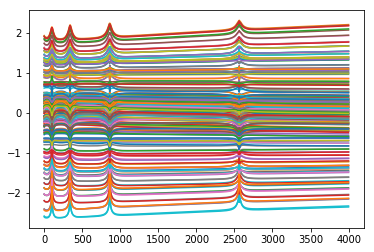

In [9]:
plt.plot(t_scaled[0:205].T);

In [11]:
H = 256
def generator():
    x = Input(shape=(X[0].shape[0],))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deeper.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 4000)              1028000   
Total params: 1,226,144
Trainable params: 1,226,144
Non-trainable params: 0
_________________________________________________________________


In [60]:
for i in tqdm(range(1)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 2500
    batch = 32
    
    h = model.fit(X_scaled,t_scaled, epochs = n_epochs, verbose = 1, batch_size = batch, shuffle = True)
    history = np.append(history, h.history['loss'])
    model.save_weights('model_interp_deeper.h5')


  0%|          | 0/1 [00:00<?, ?it/s]

Training meta-batch 0
Epoch 1/2500
1040/1040 [==============================] - 1s 484us/step - loss: 3.3202e-05 - mean_absolute_error: 0.0041
Epoch 2/2500
1040/1040 [==============================] - 0s 476us/step - loss: 4.9330e-06 - mean_absolute_error: 0.0017
Epoch 3/2500
1040/1040 [==============================] - 0s 463us/step - loss: 2.5052e-06 - mean_absolute_error: 0.0012
Epoch 4/2500
1040/1040 [==============================] - 0s 421us/step - loss: 1.1331e-06 - mean_absolute_error: 7.7833e-04
Epoch 5/2500
1040/1040 [==============================] - 0s 397us/step - loss: 1.3991e-06 - mean_absolute_error: 8.5821e-04
Epoch 6/2500
1040/1040 [==============================] - 0s 398us/step - loss: 1.3218e-06 - mean_absolute_error: 8.1719e-04
Epoch 7/2500
1040/1040 [==============================] - 0s 408us/step - loss: 1.2813e-06 - mean_absolute_error: 8.1247e-04
Epoch 8/2500
1040/1040 [==============================] - 0s 392us/step - loss: 1.7152e-06 - mean_absolute_error: 9

1040/1040 [==============================] - 0s 402us/step - loss: 1.1014e-05 - mean_absolute_error: 0.0023
Epoch 68/2500
1040/1040 [==============================] - 0s 425us/step - loss: 1.6711e-06 - mean_absolute_error: 9.6104e-04
Epoch 69/2500
1040/1040 [==============================] - 0s 454us/step - loss: 1.4731e-06 - mean_absolute_error: 9.2235e-04
Epoch 70/2500
1040/1040 [==============================] - 0s 451us/step - loss: 1.0383e-06 - mean_absolute_error: 7.3119e-04
Epoch 71/2500
1040/1040 [==============================] - 0s 458us/step - loss: 4.5018e-06 - mean_absolute_error: 0.0015
Epoch 72/2500
1040/1040 [==============================] - 0s 458us/step - loss: 8.1584e-06 - mean_absolute_error: 0.0022
Epoch 73/2500
1040/1040 [==============================] - 0s 464us/step - loss: 3.0715e-06 - mean_absolute_error: 0.0013
Epoch 74/2500
1040/1040 [==============================] - 0s 456us/step - loss: 2.9571e-06 - mean_absolute_error: 0.0013
Epoch 75/2500
1040/1040 [=

1040/1040 [==============================] - 0s 450us/step - loss: 2.1919e-06 - mean_absolute_error: 0.0011
Epoch 134/2500
1040/1040 [==============================] - 1s 483us/step - loss: 7.9848e-06 - mean_absolute_error: 0.0020
Epoch 135/2500
1040/1040 [==============================] - 0s 462us/step - loss: 9.9910e-06 - mean_absolute_error: 0.0023
Epoch 136/2500
1040/1040 [==============================] - 0s 443us/step - loss: 4.2753e-06 - mean_absolute_error: 0.0015
Epoch 137/2500
1040/1040 [==============================] - 0s 443us/step - loss: 3.6683e-06 - mean_absolute_error: 0.0013
Epoch 138/2500
1040/1040 [==============================] - 0s 442us/step - loss: 1.0561e-04 - mean_absolute_error: 0.0072
Epoch 139/2500
1040/1040 [==============================] - 0s 435us/step - loss: 3.2450e-05 - mean_absolute_error: 0.0044
Epoch 140/2500
1040/1040 [==============================] - 0s 440us/step - loss: 2.0495e-05 - mean_absolute_error: 0.0034
Epoch 141/2500
1040/1040 [=====

1040/1040 [==============================] - 0s 454us/step - loss: 2.6435e-05 - mean_absolute_error: 0.0038
Epoch 200/2500
1040/1040 [==============================] - 0s 439us/step - loss: 2.3156e-05 - mean_absolute_error: 0.0035
Epoch 201/2500
1040/1040 [==============================] - 0s 450us/step - loss: 3.7715e-06 - mean_absolute_error: 0.0015
Epoch 202/2500
1040/1040 [==============================] - 0s 449us/step - loss: 7.4262e-06 - mean_absolute_error: 0.0020
Epoch 203/2500
1040/1040 [==============================] - 0s 450us/step - loss: 2.1177e-05 - mean_absolute_error: 0.0034
Epoch 204/2500
1040/1040 [==============================] - 0s 446us/step - loss: 3.5509e-06 - mean_absolute_error: 0.0014
Epoch 205/2500
1040/1040 [==============================] - 0s 440us/step - loss: 3.6291e-06 - mean_absolute_error: 0.0013
Epoch 206/2500
1040/1040 [==============================] - 0s 446us/step - loss: 2.3660e-05 - mean_absolute_error: 0.0033
Epoch 207/2500
1040/1040 [=====

1040/1040 [==============================] - 0s 374us/step - loss: 2.2679e-06 - mean_absolute_error: 0.0011
Epoch 265/2500
1040/1040 [==============================] - 0s 383us/step - loss: 5.2287e-06 - mean_absolute_error: 0.0014
Epoch 266/2500
1040/1040 [==============================] - 0s 383us/step - loss: 2.6404e-05 - mean_absolute_error: 0.0036
Epoch 267/2500
1040/1040 [==============================] - 0s 394us/step - loss: 6.1885e-06 - mean_absolute_error: 0.0019
Epoch 268/2500
1040/1040 [==============================] - 0s 394us/step - loss: 4.2611e-06 - mean_absolute_error: 0.0015
Epoch 269/2500
1040/1040 [==============================] - 0s 385us/step - loss: 2.1642e-06 - mean_absolute_error: 0.0011
Epoch 270/2500
1040/1040 [==============================] - 0s 385us/step - loss: 2.0176e-06 - mean_absolute_error: 0.0011
Epoch 271/2500
1040/1040 [==============================] - 0s 387us/step - loss: 4.3691e-06 - mean_absolute_error: 0.0015
Epoch 272/2500
1040/1040 [=====

1040/1040 [==============================] - 0s 387us/step - loss: 2.7454e-06 - mean_absolute_error: 0.0012
Epoch 331/2500
1040/1040 [==============================] - 0s 388us/step - loss: 1.2920e-06 - mean_absolute_error: 8.3887e-04
Epoch 332/2500
1040/1040 [==============================] - 0s 392us/step - loss: 9.3972e-07 - mean_absolute_error: 7.0138e-04
Epoch 333/2500
1040/1040 [==============================] - 0s 386us/step - loss: 1.6547e-06 - mean_absolute_error: 9.1763e-04
Epoch 334/2500
1040/1040 [==============================] - 0s 410us/step - loss: 2.3249e-06 - mean_absolute_error: 0.0011
Epoch 335/2500
1040/1040 [==============================] - 0s 395us/step - loss: 1.4918e-06 - mean_absolute_error: 9.0525e-04
Epoch 336/2500
1040/1040 [==============================] - 0s 411us/step - loss: 1.6480e-06 - mean_absolute_error: 9.2916e-04
Epoch 337/2500
1040/1040 [==============================] - 0s 379us/step - loss: 1.0475e-06 - mean_absolute_error: 7.2891e-04
Epoch 3

1040/1040 [==============================] - 0s 439us/step - loss: 7.7033e-07 - mean_absolute_error: 5.9656e-04
Epoch 396/2500
1040/1040 [==============================] - 0s 433us/step - loss: 8.8002e-07 - mean_absolute_error: 6.4447e-04
Epoch 397/2500
1040/1040 [==============================] - 0s 446us/step - loss: 1.1651e-06 - mean_absolute_error: 7.6485e-04
Epoch 398/2500
1040/1040 [==============================] - 0s 440us/step - loss: 1.4026e-06 - mean_absolute_error: 8.7772e-04
Epoch 399/2500
1040/1040 [==============================] - 0s 437us/step - loss: 1.3707e-06 - mean_absolute_error: 8.7077e-04
Epoch 400/2500
1040/1040 [==============================] - 0s 435us/step - loss: 1.2637e-06 - mean_absolute_error: 7.2151e-04
Epoch 401/2500
1040/1040 [==============================] - 0s 432us/step - loss: 1.6082e-06 - mean_absolute_error: 9.2652e-04
Epoch 402/2500
1040/1040 [==============================] - 0s 437us/step - loss: 1.3147e-06 - mean_absolute_error: 8.2380e-04

1040/1040 [==============================] - 0s 450us/step - loss: 2.0230e-06 - mean_absolute_error: 0.0011
Epoch 461/2500
1040/1040 [==============================] - 0s 449us/step - loss: 1.8565e-06 - mean_absolute_error: 9.9838e-04
Epoch 462/2500
1040/1040 [==============================] - 0s 439us/step - loss: 1.0281e-06 - mean_absolute_error: 7.3902e-04
Epoch 463/2500
1040/1040 [==============================] - 0s 456us/step - loss: 1.2517e-06 - mean_absolute_error: 8.3340e-04
Epoch 464/2500
1040/1040 [==============================] - 0s 438us/step - loss: 1.0956e-06 - mean_absolute_error: 7.4926e-04
Epoch 465/2500
1040/1040 [==============================] - 0s 459us/step - loss: 1.5613e-06 - mean_absolute_error: 9.2487e-04
Epoch 466/2500
1040/1040 [==============================] - 0s 457us/step - loss: 1.7353e-06 - mean_absolute_error: 9.6728e-04
Epoch 467/2500
1040/1040 [==============================] - 0s 452us/step - loss: 1.5351e-06 - mean_absolute_error: 9.2812e-04
Epo

1040/1040 [==============================] - 0s 378us/step - loss: 9.8313e-05 - mean_absolute_error: 0.0071
Epoch 526/2500
1040/1040 [==============================] - 0s 377us/step - loss: 4.8391e-05 - mean_absolute_error: 0.0053
Epoch 527/2500
1040/1040 [==============================] - 0s 436us/step - loss: 3.6792e-05 - mean_absolute_error: 0.0043
Epoch 528/2500
1040/1040 [==============================] - 0s 421us/step - loss: 2.8645e-06 - mean_absolute_error: 0.0013
Epoch 529/2500
1040/1040 [==============================] - 0s 445us/step - loss: 1.8033e-06 - mean_absolute_error: 9.6874e-04
Epoch 530/2500
1040/1040 [==============================] - 0s 440us/step - loss: 1.4656e-06 - mean_absolute_error: 8.9507e-04
Epoch 531/2500
1040/1040 [==============================] - 0s 442us/step - loss: 5.8147e-06 - mean_absolute_error: 0.0019
Epoch 532/2500
1040/1040 [==============================] - 0s 439us/step - loss: 4.8723e-06 - mean_absolute_error: 0.0017
Epoch 533/2500
1040/104

1040/1040 [==============================] - 0s 398us/step - loss: 2.4922e-06 - mean_absolute_error: 0.0012
Epoch 592/2500
1040/1040 [==============================] - 0s 397us/step - loss: 4.4246e-06 - mean_absolute_error: 0.0016
Epoch 593/2500
1040/1040 [==============================] - 0s 407us/step - loss: 1.7857e-06 - mean_absolute_error: 9.9737e-04
Epoch 594/2500
1040/1040 [==============================] - 0s 412us/step - loss: 1.0783e-05 - mean_absolute_error: 0.0022
Epoch 595/2500
1040/1040 [==============================] - 0s 470us/step - loss: 9.2757e-05 - mean_absolute_error: 0.0068
Epoch 596/2500
1040/1040 [==============================] - 0s 441us/step - loss: 2.0664e-05 - mean_absolute_error: 0.0034
Epoch 597/2500
1040/1040 [==============================] - 0s 416us/step - loss: 1.1242e-05 - mean_absolute_error: 0.0026
Epoch 598/2500
1040/1040 [==============================] - 0s 392us/step - loss: 3.1264e-06 - mean_absolute_error: 0.0013
Epoch 599/2500
1040/1040 [=

1040/1040 [==============================] - 0s 446us/step - loss: 8.5160e-07 - mean_absolute_error: 6.6590e-04
Epoch 658/2500
1040/1040 [==============================] - 0s 451us/step - loss: 2.0543e-06 - mean_absolute_error: 0.0011
Epoch 659/2500
1040/1040 [==============================] - 0s 452us/step - loss: 1.5665e-06 - mean_absolute_error: 9.4126e-04
Epoch 660/2500
1040/1040 [==============================] - 0s 463us/step - loss: 9.1131e-07 - mean_absolute_error: 6.8252e-04
Epoch 661/2500
1040/1040 [==============================] - 0s 468us/step - loss: 9.6518e-07 - mean_absolute_error: 6.6866e-04
Epoch 662/2500
1040/1040 [==============================] - 0s 457us/step - loss: 1.0258e-06 - mean_absolute_error: 7.2295e-04
Epoch 663/2500
1040/1040 [==============================] - 0s 431us/step - loss: 8.7835e-07 - mean_absolute_error: 6.6114e-04
Epoch 664/2500
1040/1040 [==============================] - 0s 443us/step - loss: 1.0623e-06 - mean_absolute_error: 7.2394e-04
Epo

1040/1040 [==============================] - 0s 442us/step - loss: 7.0525e-05 - mean_absolute_error: 0.0059
Epoch 723/2500
1040/1040 [==============================] - 0s 447us/step - loss: 1.1543e-05 - mean_absolute_error: 0.0024
Epoch 724/2500
1040/1040 [==============================] - 0s 441us/step - loss: 5.1894e-06 - mean_absolute_error: 0.0017
Epoch 725/2500
1040/1040 [==============================] - 0s 443us/step - loss: 2.4894e-06 - mean_absolute_error: 0.0012
Epoch 726/2500
1040/1040 [==============================] - 0s 436us/step - loss: 1.8493e-06 - mean_absolute_error: 0.0010
Epoch 727/2500
1040/1040 [==============================] - 0s 446us/step - loss: 1.5160e-06 - mean_absolute_error: 8.7936e-04
Epoch 728/2500
1040/1040 [==============================] - 0s 444us/step - loss: 2.5218e-06 - mean_absolute_error: 0.0011
Epoch 729/2500
1040/1040 [==============================] - 0s 459us/step - loss: 8.2424e-06 - mean_absolute_error: 0.0021
Epoch 730/2500
1040/1040 [=

1040/1040 [==============================] - 0s 388us/step - loss: 4.7149e-05 - mean_absolute_error: 0.0053
Epoch 788/2500
1040/1040 [==============================] - 0s 385us/step - loss: 1.3111e-05 - mean_absolute_error: 0.0027
Epoch 789/2500
1040/1040 [==============================] - 0s 384us/step - loss: 2.0044e-06 - mean_absolute_error: 0.0010
Epoch 790/2500
1040/1040 [==============================] - 0s 389us/step - loss: 1.0186e-06 - mean_absolute_error: 7.2952e-04
Epoch 791/2500
1040/1040 [==============================] - 0s 391us/step - loss: 7.7722e-07 - mean_absolute_error: 6.1824e-04
Epoch 792/2500
1040/1040 [==============================] - 0s 386us/step - loss: 8.9900e-07 - mean_absolute_error: 6.5367e-04
Epoch 793/2500
1040/1040 [==============================] - 0s 381us/step - loss: 9.9450e-07 - mean_absolute_error: 7.1041e-04
Epoch 794/2500
1040/1040 [==============================] - 0s 458us/step - loss: 8.2095e-07 - mean_absolute_error: 6.3437e-04
Epoch 795/2

1040/1040 [==============================] - 0s 474us/step - loss: 1.4772e-05 - mean_absolute_error: 0.0029
Epoch 853/2500
1040/1040 [==============================] - 0s 437us/step - loss: 2.0967e-06 - mean_absolute_error: 0.0011
Epoch 854/2500
1040/1040 [==============================] - 0s 471us/step - loss: 9.9593e-07 - mean_absolute_error: 7.1285e-04
Epoch 855/2500
1040/1040 [==============================] - 0s 446us/step - loss: 9.9518e-07 - mean_absolute_error: 7.0622e-04
Epoch 856/2500
1040/1040 [==============================] - 0s 442us/step - loss: 1.7170e-06 - mean_absolute_error: 9.6201e-04
Epoch 857/2500
1040/1040 [==============================] - 0s 467us/step - loss: 1.1858e-06 - mean_absolute_error: 8.0190e-04
Epoch 858/2500
1040/1040 [==============================] - 0s 451us/step - loss: 8.6821e-07 - mean_absolute_error: 6.6426e-04
Epoch 859/2500
1040/1040 [==============================] - 0s 456us/step - loss: 7.8188e-07 - mean_absolute_error: 6.1698e-04
Epoch 8

1040/1040 [==============================] - 0s 436us/step - loss: 4.4440e-05 - mean_absolute_error: 0.0046
Epoch 918/2500
1040/1040 [==============================] - 0s 446us/step - loss: 1.9660e-05 - mean_absolute_error: 0.0034
Epoch 919/2500
1040/1040 [==============================] - 0s 437us/step - loss: 1.0065e-05 - mean_absolute_error: 0.0024
Epoch 920/2500
1040/1040 [==============================] - 0s 443us/step - loss: 1.4323e-05 - mean_absolute_error: 0.0027
Epoch 921/2500
1040/1040 [==============================] - 0s 448us/step - loss: 2.4385e-05 - mean_absolute_error: 0.0035
Epoch 922/2500
1040/1040 [==============================] - 0s 438us/step - loss: 1.6075e-05 - mean_absolute_error: 0.0028
Epoch 923/2500
1040/1040 [==============================] - 0s 425us/step - loss: 5.8186e-06 - mean_absolute_error: 0.0018
Epoch 924/2500
1040/1040 [==============================] - 0s 418us/step - loss: 4.3207e-06 - mean_absolute_error: 0.0014
Epoch 925/2500
1040/1040 [=====

1040/1040 [==============================] - 0s 433us/step - loss: 1.1664e-06 - mean_absolute_error: 8.0244e-04
Epoch 984/2500
1040/1040 [==============================] - 0s 431us/step - loss: 3.5919e-06 - mean_absolute_error: 0.0013
Epoch 985/2500
1040/1040 [==============================] - 0s 450us/step - loss: 2.6153e-05 - mean_absolute_error: 0.0036
Epoch 986/2500
1040/1040 [==============================] - 0s 439us/step - loss: 3.8203e-05 - mean_absolute_error: 0.0048
Epoch 987/2500
1040/1040 [==============================] - 0s 457us/step - loss: 7.5028e-05 - mean_absolute_error: 0.0059
Epoch 988/2500
1040/1040 [==============================] - 0s 451us/step - loss: 9.1259e-06 - mean_absolute_error: 0.0022
Epoch 989/2500
1040/1040 [==============================] - 0s 452us/step - loss: 5.8246e-06 - mean_absolute_error: 0.0018
Epoch 990/2500
1040/1040 [==============================] - 0s 459us/step - loss: 1.8188e-06 - mean_absolute_error: 9.0875e-04
Epoch 991/2500
1040/104

1040/1040 [==============================] - 0s 454us/step - loss: 4.0232e-05 - mean_absolute_error: 0.0044
Epoch 1049/2500
1040/1040 [==============================] - 0s 443us/step - loss: 8.0555e-06 - mean_absolute_error: 0.0022
Epoch 1050/2500
1040/1040 [==============================] - 0s 446us/step - loss: 5.8558e-06 - mean_absolute_error: 0.0018
Epoch 1051/2500
1040/1040 [==============================] - 0s 467us/step - loss: 2.0087e-05 - mean_absolute_error: 0.0028
Epoch 1052/2500
1040/1040 [==============================] - 0s 453us/step - loss: 7.2157e-05 - mean_absolute_error: 0.0062
Epoch 1053/2500
1040/1040 [==============================] - 0s 469us/step - loss: 2.1210e-05 - mean_absolute_error: 0.0032
Epoch 1054/2500
1040/1040 [==============================] - 0s 443us/step - loss: 3.4887e-06 - mean_absolute_error: 0.0014
Epoch 1055/2500
1040/1040 [==============================] - 0s 441us/step - loss: 1.3582e-06 - mean_absolute_error: 8.4097e-04
Epoch 1056/2500
1040

1040/1040 [==============================] - 0s 436us/step - loss: 2.1389e-06 - mean_absolute_error: 0.0011
Epoch 1114/2500
1040/1040 [==============================] - 0s 442us/step - loss: 1.4421e-06 - mean_absolute_error: 8.5513e-04
Epoch 1115/2500
1040/1040 [==============================] - 0s 435us/step - loss: 1.2612e-05 - mean_absolute_error: 0.0025
Epoch 1116/2500
1040/1040 [==============================] - 0s 434us/step - loss: 8.4852e-06 - mean_absolute_error: 0.0021
Epoch 1117/2500
1040/1040 [==============================] - 0s 437us/step - loss: 2.5885e-06 - mean_absolute_error: 0.0011
Epoch 1118/2500
1040/1040 [==============================] - 0s 432us/step - loss: 2.2967e-06 - mean_absolute_error: 0.0011
Epoch 1119/2500
1040/1040 [==============================] - 0s 430us/step - loss: 3.1113e-06 - mean_absolute_error: 0.0013
Epoch 1120/2500
1040/1040 [==============================] - 0s 434us/step - loss: 3.0636e-05 - mean_absolute_error: 0.0035
Epoch 1121/2500
1040

1040/1040 [==============================] - 0s 431us/step - loss: 4.9611e-06 - mean_absolute_error: 0.0017
Epoch 1179/2500
1040/1040 [==============================] - 0s 429us/step - loss: 5.3620e-06 - mean_absolute_error: 0.0017
Epoch 1180/2500
1040/1040 [==============================] - 0s 437us/step - loss: 2.0693e-05 - mean_absolute_error: 0.0032
Epoch 1181/2500
1040/1040 [==============================] - 0s 434us/step - loss: 5.4059e-05 - mean_absolute_error: 0.0053
Epoch 1182/2500
1040/1040 [==============================] - 0s 433us/step - loss: 6.5903e-05 - mean_absolute_error: 0.0060
Epoch 1183/2500
1040/1040 [==============================] - 0s 431us/step - loss: 3.7837e-05 - mean_absolute_error: 0.0048
Epoch 1184/2500
1040/1040 [==============================] - 0s 435us/step - loss: 2.7772e-05 - mean_absolute_error: 0.0041
Epoch 1185/2500
1040/1040 [==============================] - 0s 431us/step - loss: 1.1863e-05 - mean_absolute_error: 0.0025
Epoch 1186/2500
1040/104

1040/1040 [==============================] - 0s 439us/step - loss: 1.0829e-04 - mean_absolute_error: 0.0074
Epoch 1244/2500
1040/1040 [==============================] - 0s 442us/step - loss: 1.7502e-04 - mean_absolute_error: 0.0096
Epoch 1245/2500
1040/1040 [==============================] - 0s 435us/step - loss: 9.6755e-06 - mean_absolute_error: 0.0023
Epoch 1246/2500
1040/1040 [==============================] - 0s 432us/step - loss: 1.8424e-06 - mean_absolute_error: 9.9439e-04
Epoch 1247/2500
1040/1040 [==============================] - 0s 447us/step - loss: 1.2858e-06 - mean_absolute_error: 8.3073e-04
Epoch 1248/2500
1040/1040 [==============================] - 0s 449us/step - loss: 1.0206e-06 - mean_absolute_error: 7.2868e-04
Epoch 1249/2500
1040/1040 [==============================] - 0s 443us/step - loss: 8.3520e-07 - mean_absolute_error: 6.3876e-04
Epoch 1250/2500
1040/1040 [==============================] - 0s 434us/step - loss: 1.6250e-06 - mean_absolute_error: 9.3678e-04
Epoc

1040/1040 [==============================] - 0s 462us/step - loss: 7.9940e-07 - mean_absolute_error: 6.2727e-04
Epoch 1308/2500
1040/1040 [==============================] - 0s 468us/step - loss: 1.0617e-06 - mean_absolute_error: 7.4050e-04
Epoch 1309/2500
1040/1040 [==============================] - 0s 462us/step - loss: 1.2409e-06 - mean_absolute_error: 8.0780e-04
Epoch 1310/2500
1040/1040 [==============================] - 0s 438us/step - loss: 1.0816e-06 - mean_absolute_error: 7.2463e-04
Epoch 1311/2500
1040/1040 [==============================] - 0s 443us/step - loss: 1.2575e-06 - mean_absolute_error: 7.9354e-04
Epoch 1312/2500
1040/1040 [==============================] - 0s 452us/step - loss: 1.1127e-06 - mean_absolute_error: 7.3000e-04
Epoch 1313/2500
1040/1040 [==============================] - 0s 465us/step - loss: 1.1021e-06 - mean_absolute_error: 7.4702e-04
Epoch 1314/2500
1040/1040 [==============================] - 0s 456us/step - loss: 9.1367e-07 - mean_absolute_error: 6.7

1040/1040 [==============================] - 0s 452us/step - loss: 3.3656e-06 - mean_absolute_error: 0.0013
Epoch 1373/2500
1040/1040 [==============================] - 0s 424us/step - loss: 1.0611e-05 - mean_absolute_error: 0.0022
Epoch 1374/2500
1040/1040 [==============================] - 0s 421us/step - loss: 2.0050e-05 - mean_absolute_error: 0.0033
Epoch 1375/2500
1040/1040 [==============================] - 0s 436us/step - loss: 7.7429e-05 - mean_absolute_error: 0.0062
Epoch 1376/2500
1040/1040 [==============================] - 0s 437us/step - loss: 7.1276e-05 - mean_absolute_error: 0.0058
Epoch 1377/2500
1040/1040 [==============================] - 0s 422us/step - loss: 3.0074e-04 - mean_absolute_error: 0.0129
Epoch 1378/2500
1040/1040 [==============================] - 0s 437us/step - loss: 1.4202e-05 - mean_absolute_error: 0.0026
Epoch 1379/2500
1040/1040 [==============================] - 0s 429us/step - loss: 1.8352e-06 - mean_absolute_error: 9.8970e-04
Epoch 1380/2500
1040

1040/1040 [==============================] - 0s 448us/step - loss: 1.0548e-06 - mean_absolute_error: 7.5465e-04
Epoch 1438/2500
1040/1040 [==============================] - 0s 451us/step - loss: 8.7971e-07 - mean_absolute_error: 6.7771e-04
Epoch 1439/2500
1040/1040 [==============================] - 0s 461us/step - loss: 1.5726e-06 - mean_absolute_error: 9.2680e-04
Epoch 1440/2500
1040/1040 [==============================] - 0s 414us/step - loss: 1.0608e-06 - mean_absolute_error: 7.5256e-04
Epoch 1441/2500
1040/1040 [==============================] - 0s 399us/step - loss: 1.0557e-06 - mean_absolute_error: 7.1168e-04
Epoch 1442/2500
1040/1040 [==============================] - 0s 402us/step - loss: 1.1031e-06 - mean_absolute_error: 7.7131e-04 0s - loss: 1.1623e-06 - mean_absolute_error: 8.14
Epoch 1443/2500
1040/1040 [==============================] - 0s 381us/step - loss: 1.5269e-06 - mean_absolute_error: 9.3702e-04
Epoch 1444/2500
1040/1040 [==============================] - 0s 387us/

1040/1040 [==============================] - 0s 438us/step - loss: 3.1992e-05 - mean_absolute_error: 0.0043
Epoch 1502/2500
1040/1040 [==============================] - 0s 438us/step - loss: 6.8821e-06 - mean_absolute_error: 0.0020
Epoch 1503/2500
1040/1040 [==============================] - 0s 428us/step - loss: 5.0423e-06 - mean_absolute_error: 0.0016
Epoch 1504/2500
1040/1040 [==============================] - 0s 449us/step - loss: 2.8208e-05 - mean_absolute_error: 0.0039
Epoch 1505/2500
1040/1040 [==============================] - 0s 431us/step - loss: 2.0471e-05 - mean_absolute_error: 0.0033
Epoch 1506/2500
1040/1040 [==============================] - 0s 428us/step - loss: 9.3514e-06 - mean_absolute_error: 0.0023
Epoch 1507/2500
1040/1040 [==============================] - 0s 455us/step - loss: 3.3700e-05 - mean_absolute_error: 0.0041
Epoch 1508/2500
1040/1040 [==============================] - 0s 451us/step - loss: 8.9884e-06 - mean_absolute_error: 0.0023
Epoch 1509/2500
1040/104

1040/1040 [==============================] - 0s 401us/step - loss: 8.7179e-07 - mean_absolute_error: 6.6924e-04
Epoch 1567/2500
1040/1040 [==============================] - 0s 405us/step - loss: 8.0517e-07 - mean_absolute_error: 6.4078e-04
Epoch 1568/2500
1040/1040 [==============================] - 0s 399us/step - loss: 9.2922e-07 - mean_absolute_error: 6.8459e-04
Epoch 1569/2500
1040/1040 [==============================] - 0s 402us/step - loss: 7.9784e-07 - mean_absolute_error: 6.3004e-04
Epoch 1570/2500
1040/1040 [==============================] - 0s 379us/step - loss: 1.0002e-06 - mean_absolute_error: 7.2254e-04
Epoch 1571/2500
1040/1040 [==============================] - 0s 383us/step - loss: 1.1316e-06 - mean_absolute_error: 7.8929e-04
Epoch 1572/2500
1040/1040 [==============================] - 0s 387us/step - loss: 1.1470e-06 - mean_absolute_error: 7.8543e-04
Epoch 1573/2500
1040/1040 [==============================] - 0s 379us/step - loss: 1.3293e-06 - mean_absolute_error: 8.6

Epoch 1631/2500
1040/1040 [==============================] - 0s 441us/step - loss: 1.9492e-06 - mean_absolute_error: 0.0010
Epoch 1632/2500
1040/1040 [==============================] - 0s 459us/step - loss: 2.9338e-06 - mean_absolute_error: 0.0013
Epoch 1633/2500
1040/1040 [==============================] - 0s 438us/step - loss: 1.7560e-06 - mean_absolute_error: 9.0418e-04
Epoch 1634/2500
1040/1040 [==============================] - 0s 442us/step - loss: 1.3101e-06 - mean_absolute_error: 8.2260e-04
Epoch 1635/2500
1040/1040 [==============================] - 0s 439us/step - loss: 1.2972e-06 - mean_absolute_error: 8.2693e-04
Epoch 1636/2500
1040/1040 [==============================] - 0s 435us/step - loss: 4.9187e-06 - mean_absolute_error: 0.0017
Epoch 1637/2500
1040/1040 [==============================] - 0s 453us/step - loss: 5.0509e-06 - mean_absolute_error: 0.0015
Epoch 1638/2500
1040/1040 [==============================] - 0s 446us/step - loss: 4.1189e-06 - mean_absolute_error: 0.0

1040/1040 [==============================] - 0s 447us/step - loss: 7.7690e-06 - mean_absolute_error: 0.0020
Epoch 1697/2500
1040/1040 [==============================] - 0s 463us/step - loss: 2.6476e-05 - mean_absolute_error: 0.0035
Epoch 1698/2500
1040/1040 [==============================] - 0s 472us/step - loss: 1.2977e-04 - mean_absolute_error: 0.0085
Epoch 1699/2500
1040/1040 [==============================] - 0s 441us/step - loss: 3.9010e-05 - mean_absolute_error: 0.0048
Epoch 1700/2500
1040/1040 [==============================] - 0s 449us/step - loss: 3.2036e-05 - mean_absolute_error: 0.0043
Epoch 1701/2500
1040/1040 [==============================] - 0s 459us/step - loss: 5.8327e-06 - mean_absolute_error: 0.0018
Epoch 1702/2500
1040/1040 [==============================] - 0s 440us/step - loss: 1.5889e-06 - mean_absolute_error: 9.3956e-04
Epoch 1703/2500
1040/1040 [==============================] - 0s 442us/step - loss: 1.3254e-06 - mean_absolute_error: 8.6155e-04
Epoch 1704/2500


1040/1040 [==============================] - 0s 443us/step - loss: 7.6142e-07 - mean_absolute_error: 6.1113e-04
Epoch 1762/2500
1040/1040 [==============================] - 0s 455us/step - loss: 7.3269e-07 - mean_absolute_error: 5.9483e-04
Epoch 1763/2500
1040/1040 [==============================] - 0s 437us/step - loss: 8.9983e-07 - mean_absolute_error: 6.9510e-04
Epoch 1764/2500
1040/1040 [==============================] - 0s 464us/step - loss: 1.0881e-06 - mean_absolute_error: 7.6516e-04
Epoch 1765/2500
1040/1040 [==============================] - 0s 465us/step - loss: 7.5251e-07 - mean_absolute_error: 6.0367e-04
Epoch 1766/2500
1040/1040 [==============================] - 0s 447us/step - loss: 6.8155e-07 - mean_absolute_error: 5.6507e-04
Epoch 1767/2500
1040/1040 [==============================] - 0s 454us/step - loss: 7.7645e-07 - mean_absolute_error: 6.2020e-04
Epoch 1768/2500
1040/1040 [==============================] - 0s 431us/step - loss: 7.2470e-07 - mean_absolute_error: 5.9

1040/1040 [==============================] - 0s 465us/step - loss: 2.0469e-06 - mean_absolute_error: 0.0011
Epoch 1826/2500
1040/1040 [==============================] - 0s 462us/step - loss: 2.2892e-06 - mean_absolute_error: 0.0011
Epoch 1827/2500
1040/1040 [==============================] - 0s 455us/step - loss: 1.0433e-05 - mean_absolute_error: 0.0024
Epoch 1828/2500
1040/1040 [==============================] - 0s 462us/step - loss: 3.3177e-06 - mean_absolute_error: 0.0014
Epoch 1829/2500
1040/1040 [==============================] - 0s 459us/step - loss: 2.0714e-06 - mean_absolute_error: 0.0011
Epoch 1830/2500
1040/1040 [==============================] - 0s 460us/step - loss: 1.5862e-05 - mean_absolute_error: 0.0028
Epoch 1831/2500
1040/1040 [==============================] - 0s 447us/step - loss: 4.1427e-05 - mean_absolute_error: 0.0045
Epoch 1832/2500
1040/1040 [==============================] - 0s 455us/step - loss: 2.0548e-04 - mean_absolute_error: 0.0100
Epoch 1833/2500
1040/104

1040/1040 [==============================] - 0s 396us/step - loss: 1.3815e-06 - mean_absolute_error: 8.1547e-04
Epoch 1891/2500
1040/1040 [==============================] - 0s 398us/step - loss: 9.4075e-07 - mean_absolute_error: 7.0461e-04
Epoch 1892/2500
1040/1040 [==============================] - 0s 389us/step - loss: 8.9796e-07 - mean_absolute_error: 6.7789e-04
Epoch 1893/2500
1040/1040 [==============================] - 0s 378us/step - loss: 1.7915e-06 - mean_absolute_error: 9.5355e-04
Epoch 1894/2500
1040/1040 [==============================] - 0s 392us/step - loss: 2.2243e-06 - mean_absolute_error: 0.0011
Epoch 1895/2500
1040/1040 [==============================] - 0s 400us/step - loss: 2.4001e-06 - mean_absolute_error: 0.0011
Epoch 1896/2500
1040/1040 [==============================] - 0s 441us/step - loss: 2.0065e-06 - mean_absolute_error: 0.0011
Epoch 1897/2500
1040/1040 [==============================] - 0s 437us/step - loss: 6.1961e-06 - mean_absolute_error: 0.0019
Epoch 18

1040/1040 [==============================] - 0s 381us/step - loss: 7.3529e-07 - mean_absolute_error: 5.9701e-04
Epoch 1956/2500
1040/1040 [==============================] - 0s 383us/step - loss: 9.7470e-07 - mean_absolute_error: 7.0416e-04
Epoch 1957/2500
1040/1040 [==============================] - 0s 380us/step - loss: 1.1181e-06 - mean_absolute_error: 7.7774e-04
Epoch 1958/2500
1040/1040 [==============================] - 0s 376us/step - loss: 9.5740e-07 - mean_absolute_error: 7.0419e-04
Epoch 1959/2500
1040/1040 [==============================] - 0s 381us/step - loss: 1.5236e-06 - mean_absolute_error: 7.9315e-04
Epoch 1960/2500
1040/1040 [==============================] - 0s 393us/step - loss: 1.3810e-06 - mean_absolute_error: 8.2289e-04
Epoch 1961/2500
1040/1040 [==============================] - 0s 427us/step - loss: 2.1287e-06 - mean_absolute_error: 0.0011
Epoch 1962/2500
1040/1040 [==============================] - 0s 448us/step - loss: 3.1789e-06 - mean_absolute_error: 0.0013


1040/1040 [==============================] - 0s 428us/step - loss: 1.8537e-04 - mean_absolute_error: 0.0096
Epoch 2021/2500
1040/1040 [==============================] - 0s 425us/step - loss: 3.6633e-05 - mean_absolute_error: 0.0044
Epoch 2022/2500
1040/1040 [==============================] - 0s 442us/step - loss: 3.6824e-06 - mean_absolute_error: 0.0014
Epoch 2023/2500
1040/1040 [==============================] - 0s 433us/step - loss: 9.1941e-07 - mean_absolute_error: 6.8835e-04
Epoch 2024/2500
1040/1040 [==============================] - 0s 441us/step - loss: 9.8899e-07 - mean_absolute_error: 7.0887e-04
Epoch 2025/2500
1040/1040 [==============================] - 0s 442us/step - loss: 7.8475e-07 - mean_absolute_error: 6.1535e-04
Epoch 2026/2500
1040/1040 [==============================] - 0s 434us/step - loss: 7.4659e-07 - mean_absolute_error: 5.9501e-04
Epoch 2027/2500
1040/1040 [==============================] - 0s 434us/step - loss: 1.2889e-06 - mean_absolute_error: 8.4991e-04
Epoc

1040/1040 [==============================] - 0s 461us/step - loss: 1.0583e-04 - mean_absolute_error: 0.0078
Epoch 2086/2500
1040/1040 [==============================] - 0s 461us/step - loss: 1.1710e-05 - mean_absolute_error: 0.0025
Epoch 2087/2500
1040/1040 [==============================] - 0s 463us/step - loss: 1.8338e-06 - mean_absolute_error: 9.6426e-04
Epoch 2088/2500
1040/1040 [==============================] - 0s 460us/step - loss: 1.4034e-06 - mean_absolute_error: 8.1465e-04
Epoch 2089/2500
1040/1040 [==============================] - 0s 389us/step - loss: 7.5321e-07 - mean_absolute_error: 5.9751e-04
Epoch 2090/2500
1040/1040 [==============================] - 0s 387us/step - loss: 7.1031e-07 - mean_absolute_error: 5.8557e-04
Epoch 2091/2500
1040/1040 [==============================] - 0s 399us/step - loss: 7.9553e-07 - mean_absolute_error: 6.2866e-04
Epoch 2092/2500
1040/1040 [==============================] - 0s 392us/step - loss: 7.5844e-07 - mean_absolute_error: 6.1036e-04


1040/1040 [==============================] - 0s 443us/step - loss: 5.8583e-06 - mean_absolute_error: 0.0017
Epoch 2151/2500
1040/1040 [==============================] - 0s 439us/step - loss: 9.3308e-06 - mean_absolute_error: 0.0021
Epoch 2152/2500
1040/1040 [==============================] - 0s 443us/step - loss: 1.3992e-05 - mean_absolute_error: 0.0026
Epoch 2153/2500
1040/1040 [==============================] - 0s 447us/step - loss: 8.1218e-05 - mean_absolute_error: 0.0059
Epoch 2154/2500
1040/1040 [==============================] - 0s 462us/step - loss: 9.8549e-06 - mean_absolute_error: 0.0023
Epoch 2155/2500
1040/1040 [==============================] - 0s 452us/step - loss: 2.7118e-06 - mean_absolute_error: 0.0013
Epoch 2156/2500
1040/1040 [==============================] - 0s 433us/step - loss: 1.0387e-06 - mean_absolute_error: 7.2979e-04
Epoch 2157/2500
1040/1040 [==============================] - 0s 462us/step - loss: 8.1913e-07 - mean_absolute_error: 6.3472e-04
Epoch 2158/2500


1040/1040 [==============================] - 0s 398us/step - loss: 7.3658e-07 - mean_absolute_error: 6.0439e-04
Epoch 2216/2500
1040/1040 [==============================] - 0s 390us/step - loss: 1.0044e-06 - mean_absolute_error: 7.2061e-04
Epoch 2217/2500
1040/1040 [==============================] - 0s 386us/step - loss: 1.0807e-06 - mean_absolute_error: 7.2008e-04
Epoch 2218/2500
1040/1040 [==============================] - 0s 418us/step - loss: 9.4477e-07 - mean_absolute_error: 6.8616e-04
Epoch 2219/2500
1040/1040 [==============================] - 0s 439us/step - loss: 1.1692e-06 - mean_absolute_error: 7.3496e-04
Epoch 2220/2500
1040/1040 [==============================] - 0s 440us/step - loss: 1.4811e-06 - mean_absolute_error: 8.9480e-04
Epoch 2221/2500
1040/1040 [==============================] - 0s 462us/step - loss: 9.5782e-07 - mean_absolute_error: 7.0320e-04
Epoch 2222/2500
1040/1040 [==============================] - 0s 442us/step - loss: 8.4524e-07 - mean_absolute_error: 6.6

1040/1040 [==============================] - 0s 454us/step - loss: 1.6831e-06 - mean_absolute_error: 9.7752e-04
Epoch 2280/2500
1040/1040 [==============================] - 0s 459us/step - loss: 2.8001e-06 - mean_absolute_error: 0.0013
Epoch 2281/2500
1040/1040 [==============================] - 0s 456us/step - loss: 5.2007e-06 - mean_absolute_error: 0.0018
Epoch 2282/2500
1040/1040 [==============================] - 0s 460us/step - loss: 6.6256e-06 - mean_absolute_error: 0.0019
Epoch 2283/2500
1040/1040 [==============================] - 0s 457us/step - loss: 5.9232e-06 - mean_absolute_error: 0.0017
Epoch 2284/2500
1040/1040 [==============================] - 0s 453us/step - loss: 7.1523e-06 - mean_absolute_error: 0.0020
Epoch 2285/2500
1040/1040 [==============================] - 0s 452us/step - loss: 3.1666e-06 - mean_absolute_error: 0.0013
Epoch 2286/2500
1040/1040 [==============================] - 0s 461us/step - loss: 7.9805e-06 - mean_absolute_error: 0.0020
Epoch 2287/2500
1040

1040/1040 [==============================] - 0s 452us/step - loss: 2.3914e-05 - mean_absolute_error: 0.0033
Epoch 2345/2500
1040/1040 [==============================] - 0s 462us/step - loss: 3.8987e-05 - mean_absolute_error: 0.0044
Epoch 2346/2500
1040/1040 [==============================] - 0s 469us/step - loss: 9.6731e-06 - mean_absolute_error: 0.0024
Epoch 2347/2500
1040/1040 [==============================] - 0s 474us/step - loss: 4.5606e-06 - mean_absolute_error: 0.0016
Epoch 2348/2500
1040/1040 [==============================] - 0s 458us/step - loss: 7.4720e-06 - mean_absolute_error: 0.0019
Epoch 2349/2500
1040/1040 [==============================] - 0s 462us/step - loss: 3.9917e-06 - mean_absolute_error: 0.0014
Epoch 2350/2500
1040/1040 [==============================] - 0s 453us/step - loss: 1.6003e-06 - mean_absolute_error: 9.4451e-04
Epoch 2351/2500
1040/1040 [==============================] - 0s 446us/step - loss: 2.6028e-06 - mean_absolute_error: 0.0012
Epoch 2352/2500
1040

1040/1040 [==============================] - 0s 386us/step - loss: 1.4131e-06 - mean_absolute_error: 8.1448e-04
Epoch 2410/2500
1040/1040 [==============================] - 0s 385us/step - loss: 1.7354e-06 - mean_absolute_error: 8.5595e-04
Epoch 2411/2500
1040/1040 [==============================] - 0s 408us/step - loss: 1.4493e-06 - mean_absolute_error: 7.8432e-04
Epoch 2412/2500
1040/1040 [==============================] - 0s 440us/step - loss: 1.4176e-06 - mean_absolute_error: 8.5816e-04
Epoch 2413/2500
1040/1040 [==============================] - 0s 444us/step - loss: 2.0593e-06 - mean_absolute_error: 0.0010
Epoch 2414/2500
1040/1040 [==============================] - 0s 421us/step - loss: 1.4836e-06 - mean_absolute_error: 8.6611e-04
Epoch 2415/2500
1040/1040 [==============================] - 0s 388us/step - loss: 1.2281e-06 - mean_absolute_error: 8.1433e-04
Epoch 2416/2500
1040/1040 [==============================] - 0s 381us/step - loss: 2.1828e-06 - mean_absolute_error: 0.0011


1040/1040 [==============================] - 0s 438us/step - loss: 6.8645e-07 - mean_absolute_error: 5.6457e-04
Epoch 2474/2500
1040/1040 [==============================] - 0s 445us/step - loss: 6.7832e-07 - mean_absolute_error: 5.5845e-04
Epoch 2475/2500
1040/1040 [==============================] - 0s 452us/step - loss: 8.5322e-07 - mean_absolute_error: 6.5897e-04
Epoch 2476/2500
1040/1040 [==============================] - 0s 455us/step - loss: 8.4396e-07 - mean_absolute_error: 6.4909e-04
Epoch 2477/2500
1040/1040 [==============================] - 0s 445us/step - loss: 8.5510e-07 - mean_absolute_error: 6.4859e-04
Epoch 2478/2500
1040/1040 [==============================] - 0s 442us/step - loss: 7.2814e-07 - mean_absolute_error: 5.9725e-04
Epoch 2479/2500
1040/1040 [==============================] - 0s 436us/step - loss: 7.5172e-07 - mean_absolute_error: 6.1647e-04
Epoch 2480/2500
1040/1040 [==============================] - 0s 439us/step - loss: 7.8534e-07 - mean_absolute_error: 6.1


100%|██████████| 1/1 [18:55<00:00, 1135.29s/it]

99.653 percent improvement


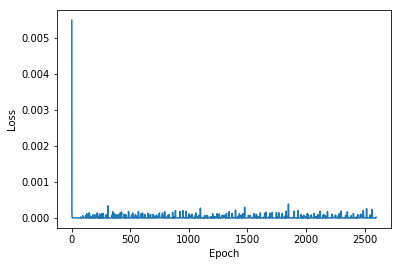

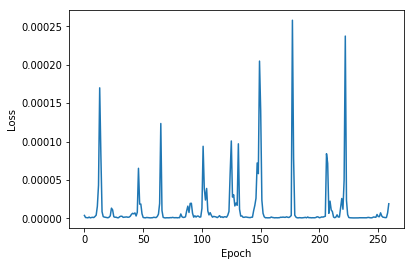

In [61]:
plt.figure()
plt.plot(history);
plt.xlabel('Epoch')
plt.ylabel('Loss')

r = int(len(history)/10)
plt.figure()
plt.plot(history[-r:]);
plt.xlabel('Epoch')
plt.ylabel('Loss')
print('%.3f percent improvement'%(100*(history[0] - history[-1])/history[0]))

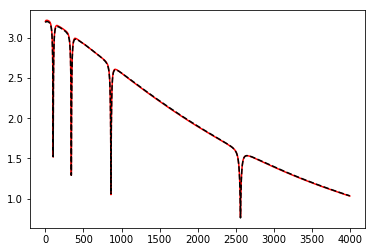

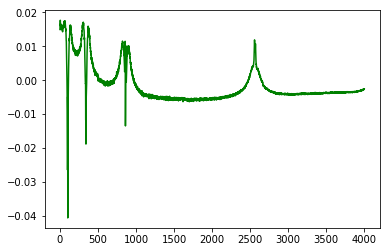

In [66]:
n = np.random.randint(0,len(X))
label = X_scaled[n].reshape(1,-1)
true = np.exp(t[n])
pred = np.exp(msc.inverse_transform(model.predict(label)))[0,:]
plt.plot(true,'k--',zorder=8)
plt.plot(pred,'r-')
plt.figure()
plt.plot(pred-true,'g-')

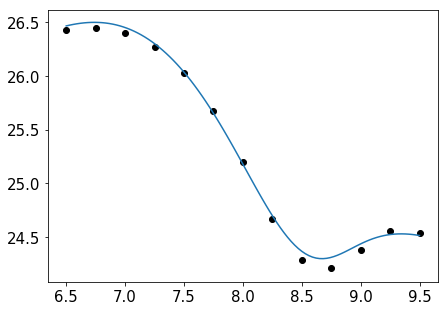

In [74]:
pixel = 221
temp = 14000


ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux = np.exp(t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = np.exp(msc.inverse_transform(model.predict(sc.transform(linlabels))))[:,pixel]
plt.plot(linls,lintflux)

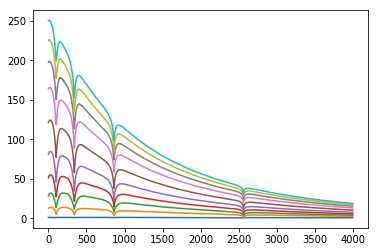

In [54]:
n = 10
ls = np.linspace(8,8,n)
ts = np.linspace(6000,50000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

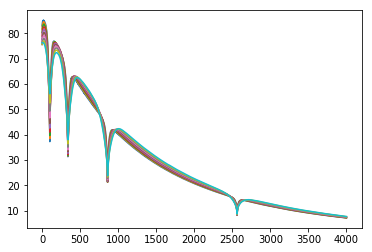

In [55]:
n = 10
ls = np.linspace(6.5,9.5,n)
ts = np.linspace(25000,25000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

In [56]:
def ch_cont(array):
    spec = array
    lamgrid = np.linspace(4000,8000,4000)
    p = np.polynomial.chebyshev.chebfit(lamgrid,spec,4)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    plt.plot(contcorr)
    return contcorr

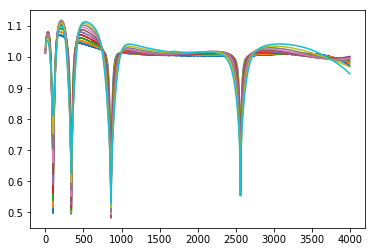

In [57]:
cpreds = [];
diffs = np.repeat(0,4000)
for i in range(len(preds)):
    cpreds.append(ch_cont(preds[i]))
cpreds = np.asarray(cpreds)

In [58]:
contbool = (np.ptp(cpreds,0) < 0.04)

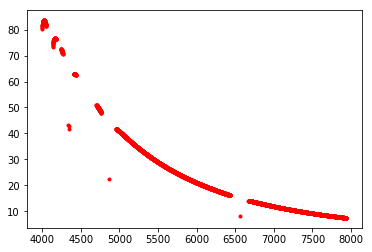

In [59]:
plt.plot(lamgrid[contbool],preds[2][contbool],'r.')